In [103]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# Load Data
train = pd.read_csv("files/train.csv")
test = pd.read_csv("files/test.csv")
test_copy = test.copy()

train.head()
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [104]:
# Checking for missing values
missing_counts = train.isna().sum().sort_values(ascending=False)
missing_percent = (missing_counts / train.shape[0]) * 100
missing_df = pd.DataFrame({
    'Feature': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})
print("Missing values (sorted by count):")
display(missing_df[missing_df['Missing_Count']>0])

Missing values (sorted by count):


,Feature,Missing_Count,Missing_Percent
0,PoolQC,1453,99.520548
1,MiscFeature,1406,96.301370
2,Alley,1369,93.767123
3,Fence,1179,80.753425
4,MasVnrType,872,59.726027
5,FireplaceQu,690,47.260274
6,LotFrontage,259,17.739726
7,GarageYrBlt,81,5.547945
8,GarageCond,81,5.547945
9,GarageType,81,5.547945


In [105]:
# Handling missing values in the training data (train)
# Replace missing categorical values with "None"
categorical_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                         'GarageType', 'GarageFinish', 'BsmtQual', 'BsmtCond', 
                         'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
train[categorical_fill_none] = train[categorical_fill_none].fillna("None")

# Replace missing numerical values with 0
numerical_fill_zero = ['GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                       'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars']
train[numerical_fill_zero] = train[numerical_fill_zero].fillna(0)

# Replace LotFrontage with median value by Neighborhood
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Fill Electrical with mode
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

# Replace missing values in GarageQual and GarageCond with "None"
train[['GarageQual', 'GarageCond']] = train[['GarageQual', 'GarageCond']].fillna("None")

# Repeat the same for the test dataset
# Replace missing categorical values with "None"
test[categorical_fill_none] = test[categorical_fill_none].fillna("None")

# Replace missing numerical values with 0
test[numerical_fill_zero] = test[numerical_fill_zero].fillna(0)

# Replace LotFrontage with median value by Neighborhood
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Fill Electrical with mode
if 'Electrical' in test.columns:
    test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

# Replace missing values in GarageQual and GarageCond with "None"
if 'GarageQual' in test.columns and 'GarageCond' in test.columns:
    test[['GarageQual', 'GarageCond']] = test[['GarageQual', 'GarageCond']].fillna("None")

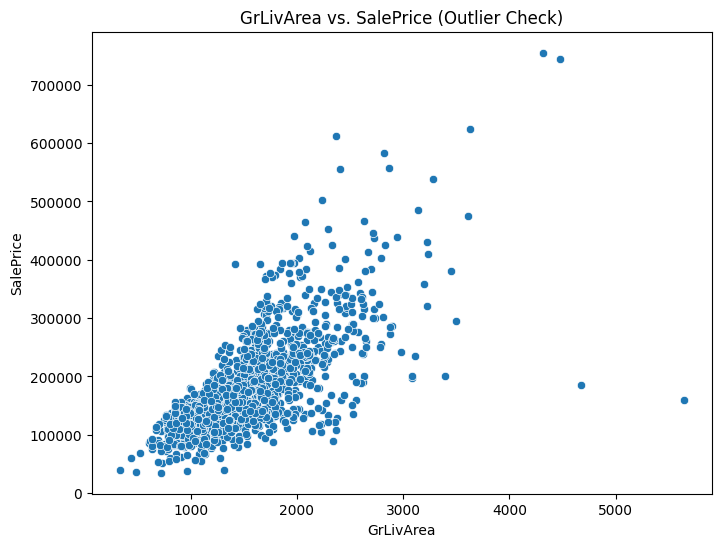

In [106]:
#Outlier Detection
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.title("GrLivArea vs. SalePrice (Outlier Check)")
plt.show()

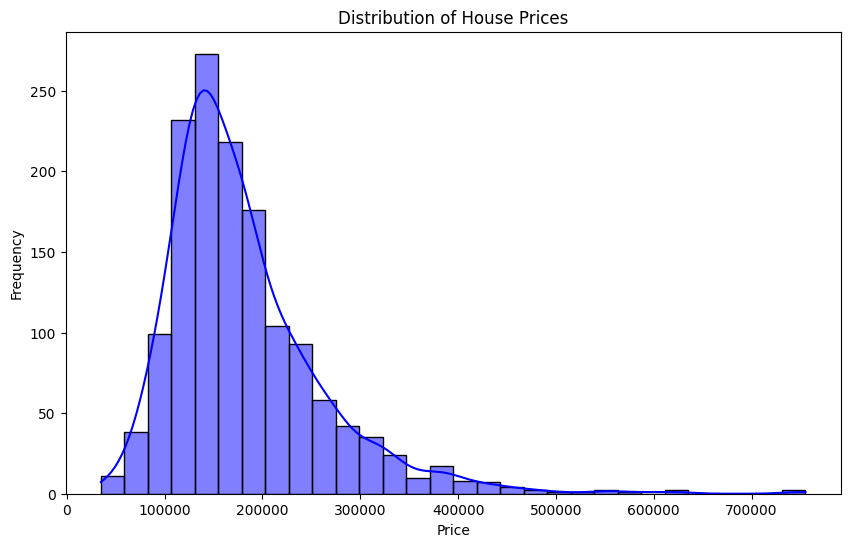

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [108]:
data = train.dropna()  # Simple approach: Drop rows with missing values

In [109]:
# Display column names (features) only
print("\nAvailable Features:")
print(train.columns.tolist())



Available Features:
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',

In [110]:
features = ['LotShape', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',]
target = 'SalePrice'

X = train[features]
y = train[target]